# Analyzing US->US Malicious Scanners

This notebook analyzes the malicious scanners that are scanning the US->US path. The data is collected from the [GreyNoise](https://greynoise.io) platform.

## Setting up

Install `pandas` library and import it.

In [ ]:
%pip install pandas matplotlib

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

Load in the data. This is a list of IPs from GreyNoise that were results for the following query:
```
metadata.country_code:US AND destination_country_code:US AND NOT spoofable:true AND classification:malicious
```
That is to say, these hosts are:
- the source of the scan is in the United States
- the destination of the scan is in the United States
- the IP is not considered *spoofable*
- the GreyNoise classification is malicious

In [7]:
df_malicious_1k = pd.read_csv('greynoise-us-us-malicious.csv')

## IP Similarity with GreyNoise

For each of the IPs, we can query the [GreyNoise IP Similarity](https://docs.greynoise.io/docs/greynoise-ip-similarity) API to see if there are any other IPs that are similar to it. This determination is a:

> combination of relatively static IP centric features, things we can derive just from knowing what IP the traffic is coming from or their connection metadata, and more dynamic behavioral features, things we see inside the traffic from that IP.

These features are:

IP Centric
- VPN
- Tor
- rDNS
- OS
- JA3 Hash
- HASSH
- Behavioral

Bot
- Spoofable
- Web Paths
- User-Agents
- Mass scanner
- Ports

Let's import the similarity data we got. It's stored in a directory called `similarity_data` (not synced).

In [26]:
data_dir = 'similarity_data'

ips_no_similarity_data = []
ips_with_similarity_data = {}

similarity_jsons = os.listdir(data_dir)

for filename in similarity_jsons:
    filepath = os.path.join(data_dir, filename)
    ip = filename.replace('.json','')
    similarity_data = json.load(open(filepath))
    if similarity_data == {"message":"ip not found"}:
        ips_no_similarity_data.append(ip)
    else:
        ips_with_similarity_data[ip] = similarity_data

In [10]:
ips_no_similarity_data_len = len(ips_no_similarity_data)
ips_no_similarity_data_pct = (ips_no_similarity_data_len / len(similarity_jsons)) * 100
ips_with_similarity_data_len = len(ips_with_similarity_data)
ips_with_similarity_data_pct = (ips_with_similarity_data_len / len(similarity_jsons)) * 100
print(f'IPs with no similarity data: {ips_no_similarity_data_len} ({ips_no_similarity_data_pct}%)')
print(f'IPs with similarity data: {ips_with_similarity_data_len} ({ips_with_similarity_data_pct}%)')

IPs with no similarity data: 664 (66.4%)
IPs with similarity data: 336 (33.6%)


Let's explore the data bit before we really dive in.

Let's see how many similar IPs we get for each of the IPs that have corresponding similarity data.

In [11]:
ip_list = []
similar_ips = []
for each in list(ips_with_similarity_data.keys()):
    ip_list.append(each)
    similar_ips.append(len(ips_with_similarity_data[each]['similar_ips']))
df_ip_similarity_volume = pd.DataFrame({'ip':ip_list, 'similar_ips':similar_ips})
df_ip_similarity_volume.sort_values(by='similar_ips', ascending=False, inplace=False)
df_ip_similarity_volume

,ip,similar_ips
0,54.163.217.167,51
1,52.23.167.222,51
2,91.246.58.131,50
3,35.171.146.218,50
4,18.209.99.212,50
...,...,...
331,99.6.126.145,50
332,207.171.232.91,50
333,216.240.41.165,29
334,64.20.63.126,1


Interesting at the bottom there is an IP `165.227.107.223` that have similarity data, but ultimately do not have any entries in the list of `similar_ips`. 

Looks like a lot of these may have 50 matches-- I wonder if that is a threshold? Though two IPs here have 51 matches.

<AxesSubplot: ylabel='Frequency'>

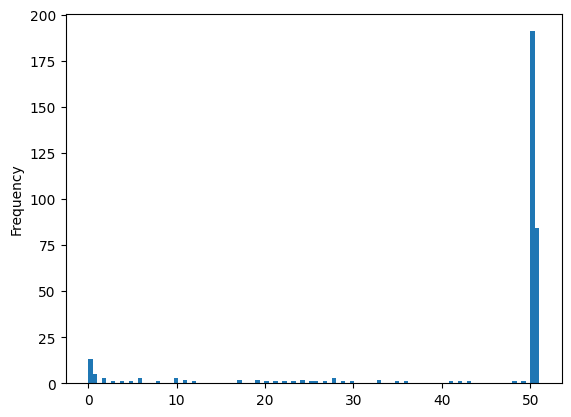

In [12]:
df_ip_similarity_volume['similar_ips'].plot.hist(bins=100)

Yeah so looks like MOST of these have 50 matches. I wonder if it's the same 50? this is something relationship mapping in a graph could help with.

## Creating a Relationship Graph with IP Similarity

Let's start by using a class object to store data a bit easier.

In [13]:
# create the RelatedIPObject first since it will be part of the IPObject
class RelatedIPObject:
    def __init__(self, related_ip_data: dict):
        self.ip = related_ip_data['ip']
        try:
            self.actor = related_ip_data['actor']
        except:
            self.actor = None
        try:
            self.classification = related_ip_data['classification']
        except:
            self.classification = None
        try:
            self.first_seen = related_ip_data['first_seen']
        except:
            self.first_seen = None
        try:
            self.last_seen = related_ip_data['last_seen']
        except:
            self.last_seen = None
        try:
            self.asn = related_ip_data['asn']
        except:
            self.asn = None
        try:
            self.city = related_ip_data['city']
        except:
            self.city = None
        try:
            self.country = related_ip_data['country']
        except:
            self.country = None
        try:
            self.country_code = related_ip_data['country_code']
        except:
            self.country_code = None
        try:
            self.organization = related_ip_data['organization']
        except:
            self.organization = None
        try:
            self.features = related_ip_data['features']
        except:
            self.features = None
        try:
            self.score = related_ip_data['score']
        except:
            self.score = None
        
    def to_json(self):
        return json.dumps(self, default=lambda o: o.__dict__)
    
    def to_dict(self):
        return json.loads(self.to_json())
    
    def __repr__(self):
        return self.to_json()

class IPObject:
    def __init__(self, ip: str):
        try:
            self.ip = ip
        except:
            self.ip = None
        try:
            self.actor = ips_with_similarity_data[self.ip]['actor']
        except:
            self.actor = None
        try:
            self.classification = ips_with_similarity_data[self.ip]['classification']
        except:
            self.classification = None
        try:
            self.first_seen = ips_with_similarity_data[self.ip]['first_seen']
        except:
            self.first_seen = None
        try:
            self.last_seen = ips_with_similarity_data[self.ip]['last_seen']
        except:
            self.last_seen = None
        try:
            self.asn = ips_with_similarity_data[self.ip]['asn']
        except:
            self.asn = None
        try:
            self.city = ips_with_similarity_data[self.ip]['city']
        except:
            self.city = None
        try:
            self.country = ips_with_similarity_data[self.ip]['country']
        except:
            self.country = None
        try:
            self.country_code = ips_with_similarity_data[self.ip]['country_code']
        except:
            self.country_code = None
        try:
            self.organization = ips_with_similarity_data[self.ip]['organization']
        except:
            self.organization = None
        try:
            self.similar_ips = [RelatedIPObject(related_ip_data) for related_ip_data in ips_with_similarity_data[self.ip]['similar_ips']]
        except:
            self.similar_ips = None
    
    def to_json(self):
        return json.dumps(self, default=lambda o: o.__dict__)
    
    def to_dict(self):
        return json.loads(self.to_json())
    
    def __repr__(self):
        return self.to_json()

And then we turn our IP data into IP Objects.

In [14]:
IP_object_list = []
for IP in list(ips_with_similarity_data.keys()):
    IP_object_list.append(IPObject(IP))

Let's check it out! Let's print one of the smaller IPObjects at the bottom of the list.

In [15]:
IP_object_list[-2].to_dict()

{'ip': '64.20.63.126',
 'actor': None,
 'classification': None,
 'first_seen': None,
 'last_seen': None,
 'asn': None,
 'city': None,
 'country': None,
 'country_code': None,
 'organization': None,
 'similar_ips': [{'ip': '64.20.56.82',
   'actor': 'unknown',
   'classification': 'unknown',
   'first_seen': '2022-09-27',
   'last_seen': '2022-10-19',
   'asn': 'AS19318',
   'city': 'New York City',
   'country': 'United States',
   'country_code': 'US',
   'organization': 'Interserver, Inc',
   'features': ['ja3_fp', 'os', 'ports', 'useragents', 'web_paths'],
   'score': 0.7938289}]}

Cool. So far starters, we can come up with a directional graph based on a given IP, it's related IP, and the `similar_ips.[].score` between the two.

In [16]:
# Let's prep arrays for a dataframe
ip_prime_list = []
ip_related_list = []
score_list = []

for IP_object in IP_object_list:
    for related_ip in IP_object.similar_ips:
        ip_prime_list.append(IP_object.ip)
        ip_related_list.append(related_ip.ip)
        score_list.append(related_ip.score)
    
df_ip_similarity = pd.DataFrame({'ip_prime':ip_prime_list, 'ip_related':ip_related_list, 'score':score_list})
df_ip_similarity

,ip_prime,ip_related,score
0,54.163.217.167,34.238.124.121,1.000000
1,54.163.217.167,44.202.110.152,1.000000
2,54.163.217.167,35.173.232.9,1.000000
3,54.163.217.167,3.87.194.15,1.000000
4,54.163.217.167,3.84.141.46,1.000000
...,...,...,...
14729,216.240.41.165,223.199.20.196,0.782323
14730,216.240.41.165,222.142.194.80,0.775888
14731,216.240.41.165,125.43.51.148,0.774351
14732,216.240.41.165,115.48.149.157,0.768010


Awesome. we end up with 14k+ individual relationships.

In [17]:
# lets write that to a csv real quick.
df_ip_similarity.to_csv('ip_similarity.csv', index=False)

Let's install the `networkx` package to help us visualize the network.

In [ ]:
%pip install networkx scipy

In [19]:
import networkx as nx

In [20]:
# create an empty graph
G = nx.Graph()

# add nodes
for row in df_ip_similarity.itertuples():
  # extract the two IP addresses and the similarity score
  index, ip1, ip2, score = row
  G.add_node(ip1)
  G.add_node(ip2)
  # add an edge to the graph between the two IP addresses
  # with the similarity score as the edge weight
  G.add_edge(ip1, ip2, weight=score)



## Visualizing the IP Similarity Network

It'll be a basic plot, but let's just check in on it using the built in `matplotlib` functionality within the `networkx` graph.

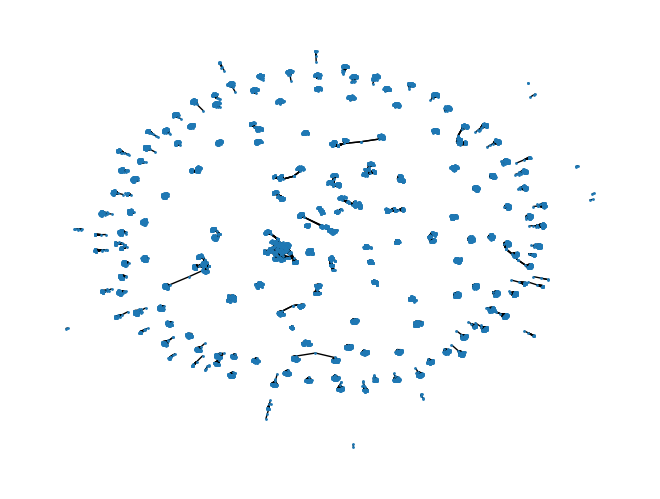

In [21]:
nx.draw(G, with_labels=False, node_size=1, font_size=2)

But we want something more slick. Let's use the `plotly` package to create an interactive graph.

In [ ]:
%pip install plotly

In [23]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

An interactive scatter plot is possible with the `scatter` method in the `plotly.express` package.

In [24]:
fig = px.scatter(df_ip_similarity, x="ip_prime", y="ip_related", color="score", size="score", hover_data=['score'])
fig.write_html("ip_similarity_scatter.html")
fig

But let's go for the network graph gusto.

In [25]:
# Set the node positions
pos = nx.layout.spring_layout(G)

In [27]:
# making lists of the nodes and text we want for hover overlay
x_node_list = []
y_node_list = []
text_list = []
for node in G.nodes:
    x_node_list.append(pos[node][0])
    y_node_list.append(pos[node][1])
    text_list.append(node)

edge_color_list = []
# Set the edge colors based on the similarity score
for (node1, node2, weight) in G.edges(data='weight'):
    edge_color_list.append(weight)


In [28]:
# setup the graph figure using plotly
fig = go.Figure(
    data=[
        go.Scatter(
            x=x_node_list,
            y=y_node_list,
            text=text_list,
            hoverinfo='text',
            mode='markers+lines'
        )
    ],
    layout=go.Layout(
        title='IP Address Network Graph, US->US malicious traffic',
        showlegend=False
    )
)


In [29]:
# write graph to html
fig.write_html("ip_similarity_graph.html")
# Show the graph
fig.show()

Meh.